# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [3]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from sklearn.utils import shuffle
import pandas as pd

# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
# Load metadata with readable cattegories
df = pd.read_csv("signnames.csv")
print(df.head())
df[df.ClassId == 2].SignName.iloc[0]

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


'Speed limit (50km/h)'

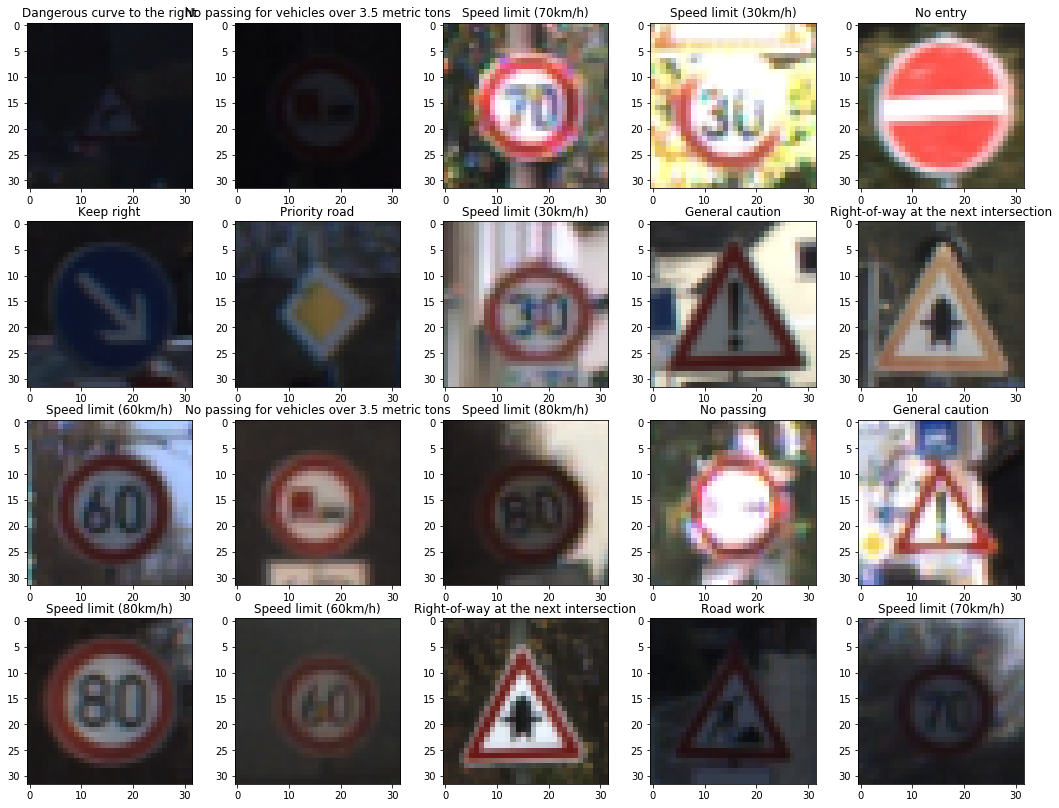

In [18]:
## Visualize random images
N_example_images = 20
columns = 5
rows = np.ceil(N_example_images/columns)

plt.figure(figsize=(18,14))
for i in range(N_example_images):
    plt.subplot(rows,columns,i+1)
    # Get random image from Train set
    index = randint(0, n_train)
    # Plot title with corresponding readable lable
    plt.title(df[df.ClassId == y_train[index]].SignName.iloc[0])
    plt.imshow(X_train[index,:])
        

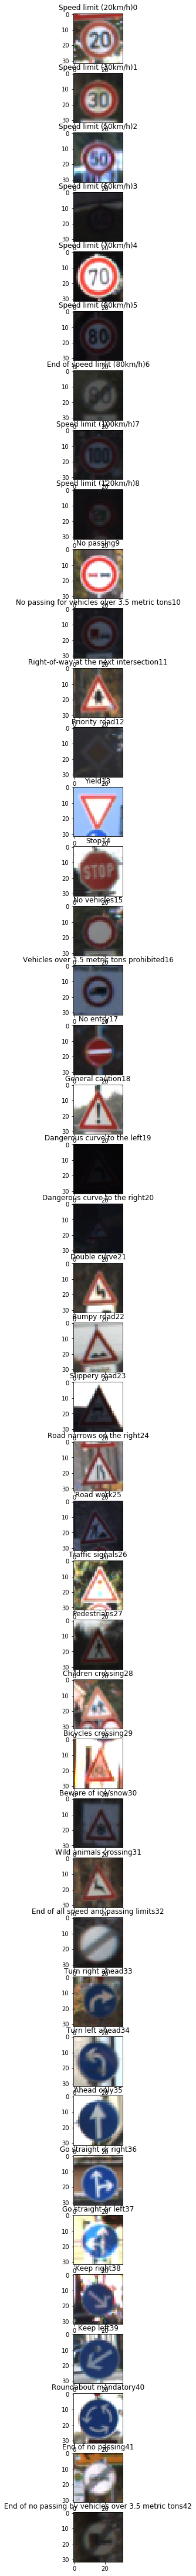

In [19]:
## Visualize All categories
N_example_images = 43

plt.figure(figsize=(12,80))
for i in range(N_example_images):
    plt.subplot(43,1,i+1)
    n_images = len(X_train[y_train == i])
    index = randint(0, n_images)
    ref_image = X_train[y_train == i][index]
    # Plot title with corresponding readable lable
    plt.title(df[df.ClassId == i].SignName.iloc[0] + str(i))
    plt.imshow(ref_image)
        

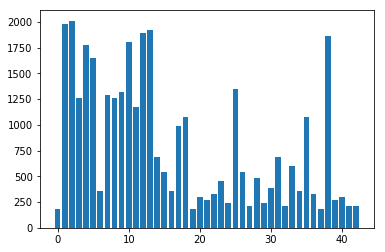

In [8]:
## Visualize data distribution
classes, repeat = np.unique(y_train,return_counts=True)

plt.bar(classes, repeat)
plt.show()

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set 

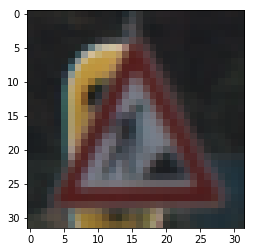

In [12]:
index = randint(0, n_train)
image = X_train[index,:]
plt.imshow(image)

#### Data Augmentation

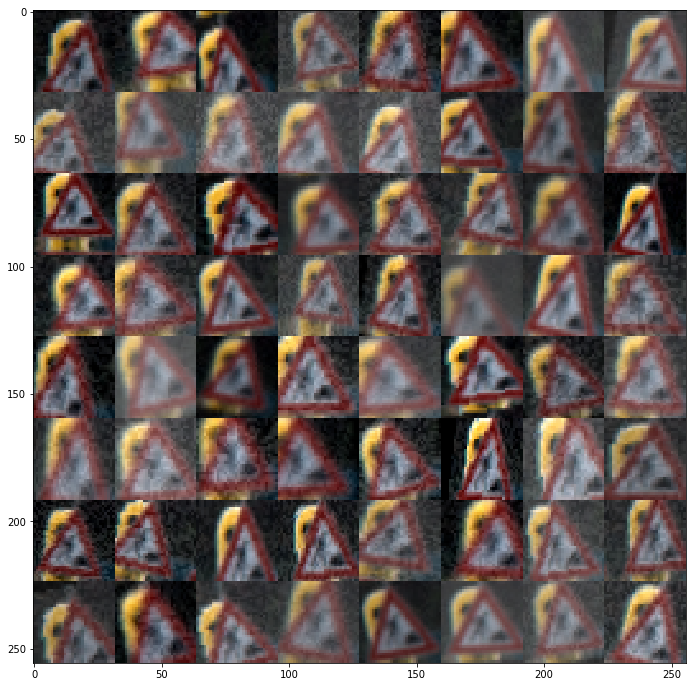

In [13]:
## Data augmentation
from imgaug import augmenters as iaa
import imgaug as ia

seq = iaa.Sequential([
    iaa.GaussianBlur((0, 1.0)),
    iaa.Crop(px=(0, 6)),
    iaa.ContrastNormalization((0.7, 1.3)),
    iaa.Multiply((1,1.5)),
    iaa.AdditivePoissonNoise((2,12)),
    iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
            rotate=(-15, 15), # rotate by -15 to +15 degrees
            shear=(-2, 2), # shear by -2 to +2 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 0), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )
], random_order=True)


plt.figure(figsize=(12,12))
seq.show_grid(image, cols=8, rows=8)

In [11]:
## Define Formal augmentator
# applies the given augmenter in 60% of all cases
sometimes = lambda aug: iaa.Sometimes(0.6, aug)

# seq = iaa.Sequential([
#     sometimes(iaa.GaussianBlur((0, 1.0))),
#     sometimes(iaa.Crop(px=(0, 6))),
#     sometimes(iaa.ContrastNormalization((0.7, 1.3))),
#     sometimes(iaa.Multiply((1,1.5))),
#     sometimes(iaa.AdditivePoissonNoise((2,12))),
#     sometimes(iaa.Affine(
#             scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
#             rotate=(-15, 15), # rotate by -15 to +15 degrees
#             shear=(-2, 2), # shear by -2 to +2 degrees
#             order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#             cval=(0, 0), # if mode is constant, use a cval between 0 and 255
#             mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#         ))
# ], random_order=True)

seq = sometimes(iaa.Sequential([
    iaa.GaussianBlur((0, 1.0)),
    iaa.Crop(px=(0, 6)),
    iaa.ContrastNormalization((0.7, 1.3)),
    iaa.Multiply((1,1.5)),
    iaa.AdditivePoissonNoise((2,12)),
    iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
            rotate=(-15, 15), # rotate by -15 to +15 degrees
            shear=(-2, 2), # shear by -2 to +2 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 0), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )
], random_order=True))

### Model Architecture

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


In [10]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def conv2d(x, W, b, strides=1,padding="VALID"):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

## Architecture
* Inputs: 3 channels 32 x 32 (RGB)
* Convolutional layer: 16 filters, kernel 5x5, padding 'same', RELU activation
* Convolutional layer: 32 filters, kernel 3x3, padding 'same', RELU activation
* Max Pool: kernel 2x2, stride 2
* Convolutional layer: 64 filters, kernel 3x3, padding 'same', RELU activation
* Max Pool: kernel 2x2, stride 2
* Convolutional layer: 64 filters, kernel 3x3, padding 'same', RELU activation
* Flatten output
* Fully connected: 2048 neurons, RELU activation, dropout = 0.6
* Fully connected: 512 neurons, RELU activation, dropout = 0.6
* Dense layer for output: 43 neurons, Softmax activation

In [11]:
def ChNet(x, dropout):    
   
    mu = 0
    sigma = 0.1
    
    # Store layers weight & bias
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 3, 16],mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal([3, 3, 16, 32],mean = mu, stddev = sigma)),
        'wc3': tf.Variable(tf.truncated_normal([3, 3, 32, 64],mean = mu, stddev = sigma)),
        'wc4': tf.Variable(tf.truncated_normal([3, 3, 64, 64],mean = mu, stddev = sigma)),
        'wd1': tf.Variable(tf.truncated_normal([8*8*64, 2048],mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.truncated_normal([2048, 512],mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal([512, n_classes],mean = mu, stddev = sigma))}

    biases = {
        'bc1': tf.Variable(tf.truncated_normal([16],mean = mu, stddev = sigma)),
        'bc2': tf.Variable(tf.truncated_normal([32],mean = mu, stddev = sigma)),
        'bc3': tf.Variable(tf.truncated_normal([64],mean = mu, stddev = sigma)),
        'bc4': tf.Variable(tf.truncated_normal([64],mean = mu, stddev = sigma)),
        'bd1': tf.Variable(tf.truncated_normal([2048],mean = mu, stddev = sigma)),
        'bd2': tf.Variable(tf.truncated_normal([512],mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal([n_classes],mean = mu, stddev = sigma))}
    
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], padding="SAME")

    # Layer 2 - 14*14*6 to 5*5*16
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], padding="SAME")
    conv2 = maxpool2d(conv2, k=2)
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'], padding="SAME")
    conv3 = maxpool2d(conv3, k=2)
    
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'], padding="SAME")

    # Fully connected layer - 5*5*16 to 400
    fc1 = flatten(conv4)
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Fully connected layer - 400 to 120
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # Output Layer - class prediction - 1024 to 10
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
       
    return logits

### Train, Validate and Test the Model

In [12]:
EPOCHS = 250
BATCH_SIZE = 128
rate = 0.001
dropout = 0.6

In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

In [22]:
logits = ChNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1,learning_rate: rate})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
max_val_acc = 0 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            # Augment Batch
            batch_x = seq.augment_images(batch_x) 
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout, learning_rate: rate})
        rate *= 0.999
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if validation_accuracy > max_val_acc: # save max val acc model
            max_val_acc = validation_accuracy
            if max_val_acc > 0.95: #only save if accuracy is more than 95%
                print("SAVING MODEL")
                saver.save(sess, './chnet')
        
        print()
        
#     saver.save(sess, './lenet')
#     print("Model saved")
    print("MAX Validation Accuracy = {:.3f}".format(max_val_acc))

Training...

EPOCH 1 ...
Validation Accuracy = 0.049

EPOCH 2 ...
Validation Accuracy = 0.055

EPOCH 3 ...
Validation Accuracy = 0.047

EPOCH 4 ...
Validation Accuracy = 0.055

EPOCH 5 ...
Validation Accuracy = 0.055

EPOCH 6 ...
Validation Accuracy = 0.055

EPOCH 7 ...
Validation Accuracy = 0.054

EPOCH 8 ...
Validation Accuracy = 0.054

EPOCH 9 ...
Validation Accuracy = 0.054

EPOCH 10 ...
Validation Accuracy = 0.054

EPOCH 11 ...
Validation Accuracy = 0.054

EPOCH 12 ...
Validation Accuracy = 0.054

EPOCH 13 ...
Validation Accuracy = 0.055

EPOCH 14 ...
Validation Accuracy = 0.076

EPOCH 15 ...
Validation Accuracy = 0.067

EPOCH 16 ...
Validation Accuracy = 0.069

EPOCH 17 ...
Validation Accuracy = 0.080

EPOCH 18 ...
Validation Accuracy = 0.083

EPOCH 19 ...
Validation Accuracy = 0.080

EPOCH 20 ...
Validation Accuracy = 0.099

EPOCH 21 ...
Validation Accuracy = 0.104

EPOCH 22 ...
Validation Accuracy = 0.114

EPOCH 23 ...
Validation Accuracy = 0.149

EPOCH 24 ...
Validation Accura

EPOCH 191 ...
Validation Accuracy = 0.963

EPOCH 192 ...
Validation Accuracy = 0.965

EPOCH 193 ...
Validation Accuracy = 0.955

EPOCH 194 ...
Validation Accuracy = 0.966

EPOCH 195 ...
Validation Accuracy = 0.959

EPOCH 196 ...
Validation Accuracy = 0.954

EPOCH 197 ...
Validation Accuracy = 0.972
SAVING MODEL

EPOCH 198 ...
Validation Accuracy = 0.963

EPOCH 199 ...
Validation Accuracy = 0.968

EPOCH 200 ...
Validation Accuracy = 0.958

EPOCH 201 ...
Validation Accuracy = 0.965

EPOCH 202 ...
Validation Accuracy = 0.956

EPOCH 203 ...
Validation Accuracy = 0.967

EPOCH 204 ...
Validation Accuracy = 0.964

EPOCH 205 ...
Validation Accuracy = 0.969

EPOCH 206 ...
Validation Accuracy = 0.970

EPOCH 207 ...
Validation Accuracy = 0.961

EPOCH 208 ...
Validation Accuracy = 0.964

EPOCH 209 ...
Validation Accuracy = 0.963

EPOCH 210 ...
Validation Accuracy = 0.961

EPOCH 211 ...
Validation Accuracy = 0.963

EPOCH 212 ...
Validation Accuracy = 0.960

EPOCH 213 ...
Validation Accuracy = 0.962

---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [1]:
import os
import cv2

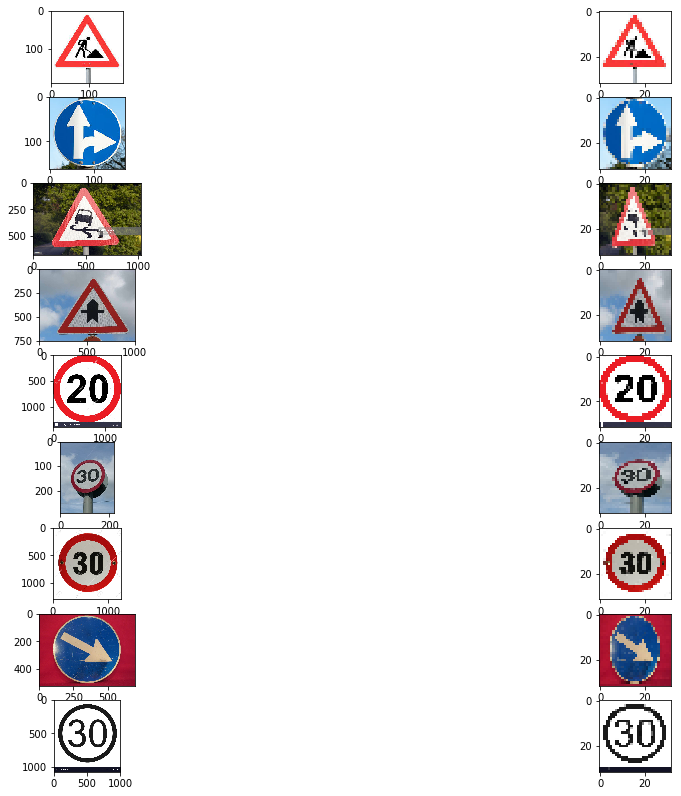

In [4]:
### Load the images and plot them here. The images are in test_images folder
folder = "test_images"
images_path = os.listdir(folder)
images = []

plt.figure(figsize=(18,14))
plt_count = 1
for i, image_path in enumerate(images_path):
    image =  cv2.cvtColor(cv2.imread(os.path.join(folder,image_path)), cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (32,32), cv2.INTER_AREA)
    
    plt.subplot(len(images_path),2,plt_count)
    plt.imshow(image)
    
    plt.subplot(len(images_path),2,plt_count+1)
    plt.imshow(image_resized)
    
    images.append(image_resized)
    
    plt_count += 2
    

### Predict the Sign Type for Each Image

In [24]:
# Define prediction operation
prediction = dict(
    class_id = tf.argmax(logits, 1),
    probabilities = tf.nn.softmax(logits)
)
images_np = np.array(images)

In [25]:
# Get prediction dat on test images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # Get prediction lables
    preds = sess.run(prediction, feed_dict={x: images_np, keep_prob: 1})
    print(preds)

INFO:tensorflow:Restoring parameters from ./chnet
{'probabilities': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0

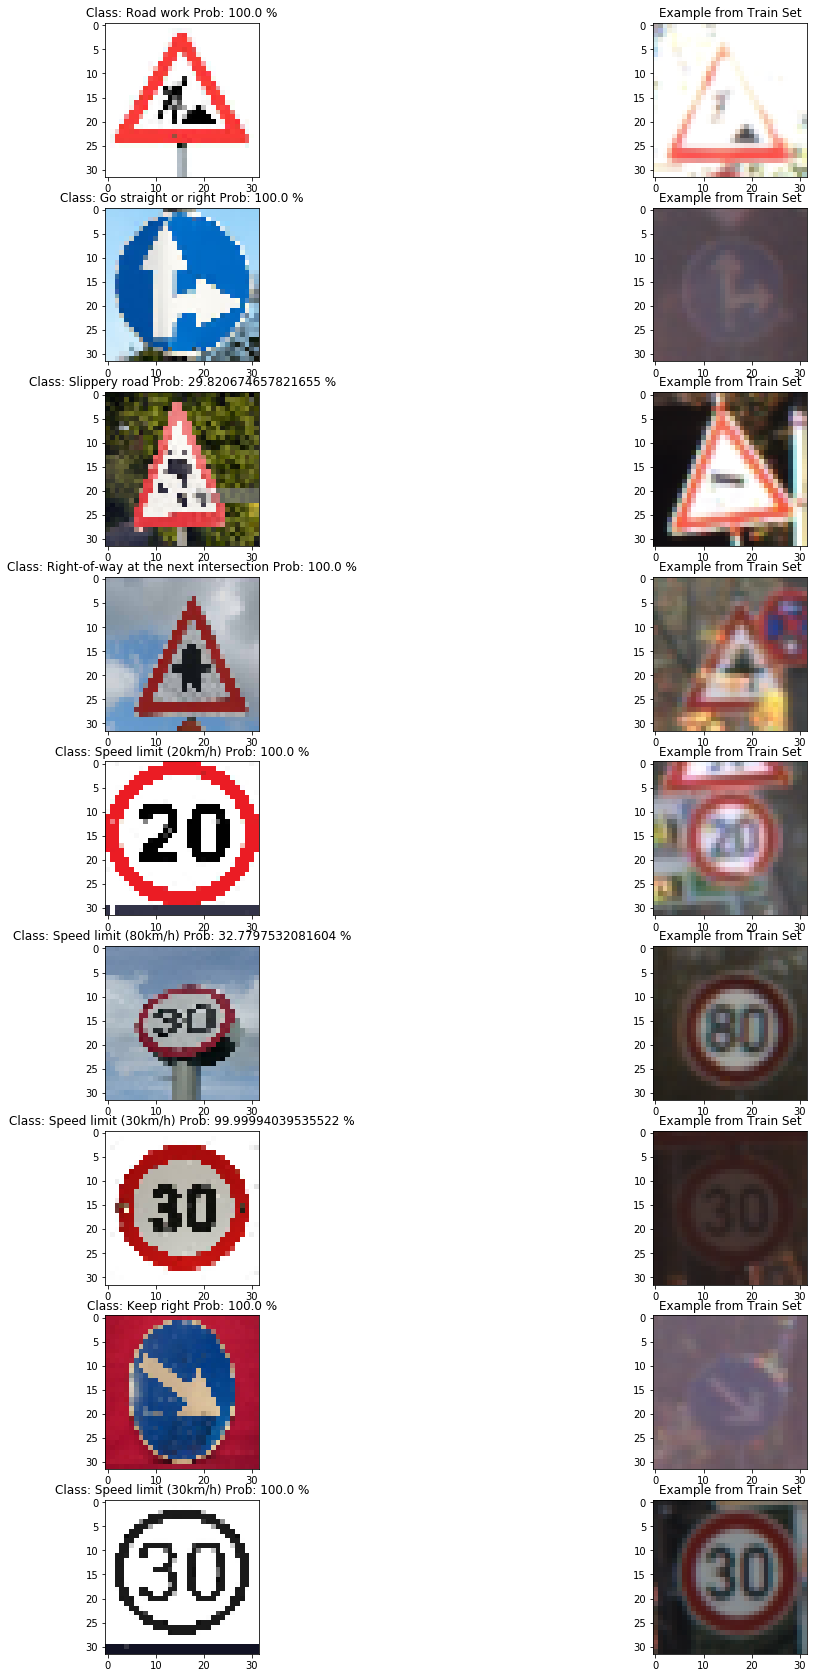

In [27]:
plt.figure(figsize=(18,30))
N = len(images)
plt_count = 1

for i in range(N):
    pred = preds["class_id"][i]
    prob = max(preds["probabilities"][i])
    class_name = df[df.ClassId == pred].SignName.iloc[0]
    
    # Plot title with corresponding readable lable
    title = "Class: {} Prob: {} %".format(class_name, prob*100)
    plt.subplot(N,2,plt_count)
    plt.title(title)
    plt.imshow(images[i])
    
    # Get reference image from training set
    n_images = len(X_train[y_train == pred])
    index = randint(0, n_images)
    ref_image = X_train[y_train == pred][index]
    plt.subplot(N,2,plt_count+1)
    plt.title("Example from Train Set")
    plt.imshow(ref_image)
    
    plt_count += 2

### Analyze Performance

In [28]:
# Define ground truth for web images
label_images = np.array([25, 36, 23, 11,  0,  1,  1, 38,  1])

In [29]:
### Calculate the accuracy for the Web images set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(images, label_images)
    print("Web Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./chnet
Web Test Accuracy = 0.889


In [30]:
### Calculate the accuracy for the Test set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./chnet
Test Accuracy = 0.951


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [31]:
# top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
output = preds["probabilities"]
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(output), k=5))
    print(top5)

TopKV2(values=array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.98206747e-01, 2.80344695e-01, 1.94462344e-01, 1.91866413e-01,
        1.76628698e-02],
       [1.00000000e+00, 1.43515148e-16, 1.08211386e-19, 1.77179867e-29,
        5.14434042e-38],
       [1.00000000e+00, 1.91923350e-19, 5.54516421e-20, 8.37641782e-21,
        2.69504208e-21],
       [3.27797532e-01, 2.76295692e-01, 1.23343773e-01, 9.40729231e-02,
        7.99926519e-02],
       [9.99999404e-01, 5.06128231e-07, 1.49975207e-07, 2.47242671e-08,
        4.08383570e-12],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 1.41262945e-12, 7.64026632e-14, 1.85259023e-15,
        8.38358278e-20]], dtype=float32), indices=array([[25,  0,  1,  2,  3],
       [36,  0,  1,  2,  3],
       [23, 19, 21, 31, 11],
 

In [39]:
for probs, indexes in zip(top5[0], top5[1]):
    print(probs, indexes)
    print()

[1. 0. 0. 0. 0.] [25  0  1  2  3]

[1. 0. 0. 0. 0.] [36  0  1  2  3]

[0.29820675 0.2803447  0.19446234 0.19186641 0.01766287] [23 19 21 31 11]

[1.00000000e+00 1.43515148e-16 1.08211386e-19 1.77179867e-29
 5.14434042e-38] [11 30 27 18 21]

[1.0000000e+00 1.9192335e-19 5.5451642e-20 8.3764178e-21 2.6950421e-21] [0 1 8 2 3]

[0.32779753 0.2762957  0.12334377 0.09407292 0.07999265] [5 7 1 4 2]

[9.9999940e-01 5.0612823e-07 1.4997521e-07 2.4724267e-08 4.0838357e-12] [1 0 2 5 4]

[1. 0. 0. 0. 0.] [38  0  1  2  3]

[1.0000000e+00 1.4126295e-12 7.6402663e-14 1.8525902e-15 8.3835828e-20] [1 2 5 0 4]



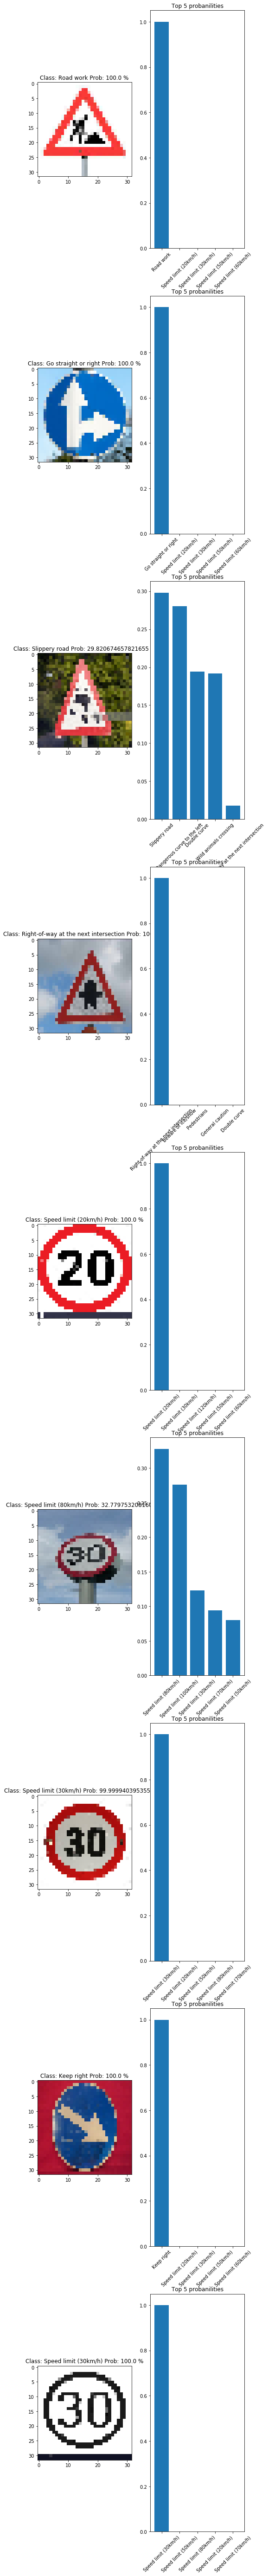

In [72]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
plt.figure(figsize=(8,100))
plt_count = 1

for i, (probs, indexes) in enumerate(zip(top5[0], top5[1])):
    pred = indexes[0]
    prob = probs[0]
    class_name = df[df.ClassId == pred].SignName.iloc[0]
    
    # Plot title with corresponding readable lable
    title = "Class: {} Prob: {} %".format(class_name, prob*100)
    plt.subplot(N,2,plt_count)
    plt.title(title)
    plt.imshow(images[i])
    
    # Get reference image from training set
    n_images = len(X_train[y_train == pred])
    index = randint(0, n_images)
    ref_image = X_train[y_train == pred][index]
    ax = plt.subplot(N,2,plt_count+1)
    

    labels = df.iloc[indexes].SignName.values
    plt.title("Top 5 probanilities")
    plt.bar(labels, probs)
#     ax.set_xticks(indexes)
    ax.set_xticklabels(labels, rotation=45)
    
    plt_count += 2



### Project Writeup

Given in the README.md

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [21]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

# def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
#     # Here make sure to preprocess your image_input in a way your network expects
#     # with size, normalization, ect if needed
#     # image_input =
#     # Note: x should be the same name as your network's tensorflow data placeholder variable
#     # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
#     activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
#     featuremaps = activation.shape[3]
#     plt.figure(plt_num, figsize=(15,15))
#     for featuremap in range(featuremaps):
#         plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
#         plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
#         if activation_min != -1 & activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
#         elif activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
#         elif activation_min !=-1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
#         else:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")